# Exploring `plasticparcels` physics kernels in an idealised flow
In this example, we will use `plasticparcels` and an idealised flow field to explore the different physics kernels available. This example requires no additional data to run.

The idealised flow is based on the two-dimensional Bickley Jet flow, where we have included a depth dimension whereby the flow velocities linearly decay with depth. Note that the physical and biogeochemical fields used in this example are unrealistic and are used for demonstration purposes only.

We will perform five experiments: 1) negatively buoyant particles advected by the flow alone, 2) positively buoyant particles advected by the flow and wind, 3) negatively buoyant particles advected by the flow, the wind, and waves, 4) negatively buoyant particles advected by the flow and by biofouling, and 5) negatively buoyant particles advected by all processes (flow, wind, waves, and biofouling).

In [1]:
# Library imports
from datetime import datetime, timedelta
import xarray as xr
import numpy as np

# parcels and plasticparcels imports
import plasticparcels as pp
import parcels

# Plotting imports
import matplotlib.pyplot as plt

## Create an idealised flow
Here, we create a 3D version of the Bickley Jet (see [Hadjighasem et al (2017)](https://aip.scitation.org/doi/10.1063/1.4982720) for details), where the velocities linearly decay with depth. In order to compute a settling velocity of plastic particles (via density differences), we create a spatially-uniform temperature and salinity field. We also include spatiotemporally varying wind, wave, and biogeochemical fields used for windage drift, Stokes drift, and biofouling kernels, respectively. We also include an 'unbeaching' field, where velocities along the top and bottom of the domain will 'kick-back' any particles that are advected across these two boundaries. The code to generate the idealised flow fields can be found in the `idealised_flow.py` file.

Since the flow is periodic in the zonal direction, we write a custom zonal boundary conditions kernel to overwrite the `plasticparcels` periodic boundary condition kernel used for longitudinal coordinates.

In [2]:
# Load the fieldset
fieldset = parcels.FieldSet.from_modulefile('idealised_flow.py')

# Add a periodic halo in the zonal direction
fieldset.add_constant("halo_west", fieldset.U.grid.lon[0])
fieldset.add_constant("halo_east", fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

In [3]:
# Define a custom kernel to handle the periodic boundary conditions
def ZonalBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

## Visualise the fields
To get a sense of what our idealised flow looks like, we will plot each field at the initial timestep. For 3D fields, we will plot the surface field only.

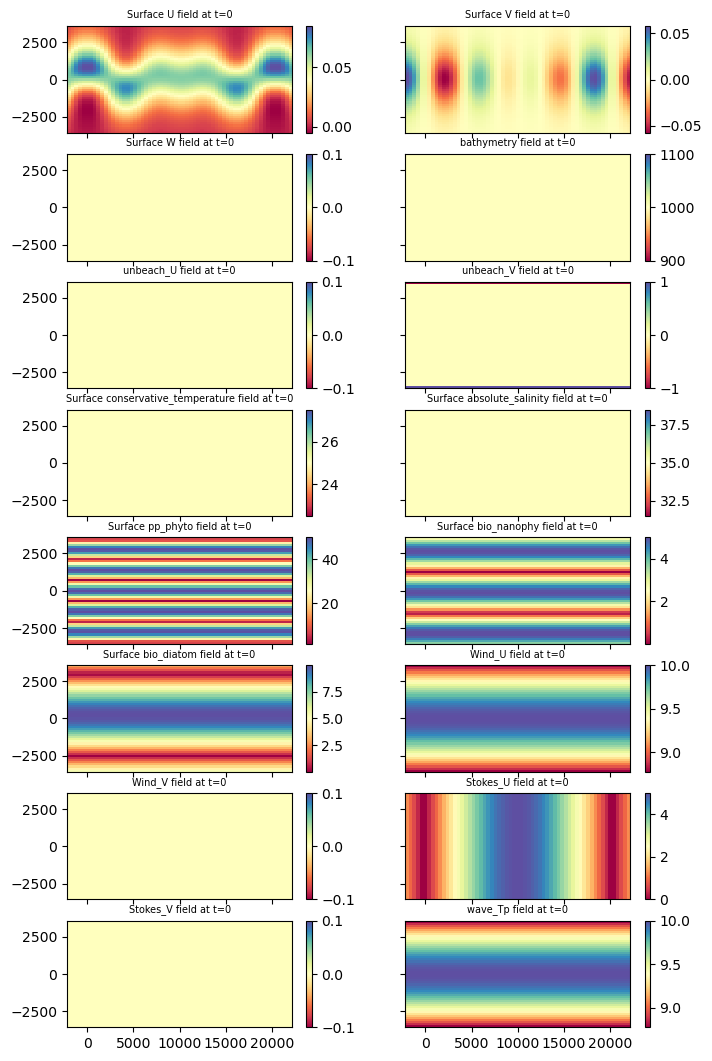

In [4]:
n_fields = len(fieldset.get_fields())
fig, axs = plt.subplots(8, 2, sharex=True, sharey=True, figsize=(8, 13))

# Loop over the fields in the fieldset, and plot them if they are Fields (and not VectorFields or NestedFields)
j = 0 # Increment if field is valid
for i in range(n_fields):
    field = fieldset.get_fields()[i]
    ax = axs.flatten()[j]

    if type(field) == parcels.Field:
        lon, lat = np.meshgrid(field.grid.lon, field.grid.lat)
        # Plot the surface field, or simply the 2D field
        if len(field.data.shape) == 4:
            field_data = field.data[0,0,:,:]
            axes_title = f'Surface {field.name} field at t=0'
        else:
            field_data = field.data[0,:,:]
            axes_title = f'{field.name} field at t=0'
        
        # Plot the field
        cb = ax.pcolormesh(lon, lat, field_data, cmap=plt.cm.Spectral)
        ax.set_title(axes_title, fontsize=7)
        plt.colorbar(cb, ax=ax)
        j +=1
   
plt.show()

## Create a dictionary of settings
As this is an idealised flow example, requiring no additional data, we don't need to import any pre-defined settings file. Instead, we can generate our own dictionary of required settings. For examples where settings dictionaries can be loaded, see some of `plasticparcels` other examples [here](https://plastic.oceanparcels.org/en/latest/examples.html).

In [5]:
settings = {}

# Create the simulation settings
settings['simulation'] = {
    'runtime': timedelta(days=4),   # Runtime of simulation
    'outputdt': timedelta(hours=6), # Timestep of output
    'dt': timedelta(minutes=5),     # Timestep of advection
    }

# Create the plastic type settings
settings['plastictype'] = {
    'wind_coefficient' : 0.1,   # Percentage of wind to apply to particles
    'plastic_diameter' : 0.001, # Plastic particle diameter (m)
    'plastic_density' : 1028.,  # Plastic particle density (kg/m^3)
}

# Set the biogeochemical model settings. These settings come from median values defined in the literature
# For more details, see Kooi et al. (2017) - 10.1021/acs.est.6b04702, Lobelle et al. (2021) - 10.1029/2020JC017098
# and Kaandorp et al. (2023) - 10.1038/s41561-023-01216-0
settings['bgc'] = {}
settings['bgc']['constants'] = {"biofilm_density": 1388.0,
                                "algae_cell_volume": 2e-16,
                                "K": 1.3805834190672156e-23,
                                "R20": 1.1574074074074074e-06,
                                "Q10": 2.13,
                                "Gamma": 2.0,
                                "carbon_molecular_weight": 12.0,
                                "collision_probability": 1.0,
                                "algae_mortality_rate": 1.0,
                                "algae_respiration_f": 0.0 # Turn off respiration
                                }

for key in settings['bgc']['constants']:
    fieldset.add_constant(key, settings['bgc']['constants'][key])

# Set the physical model settings
fieldset.add_constant('use_3D', True)
fieldset.add_constant('use_mixing', False)
fieldset.add_constant('use_biofouling', True)
fieldset.add_constant('use_stokes', True)
fieldset.add_constant('use_wind', True)
fieldset.add_constant('G', 9.81)  # Gravitational constant [m s-1]
fieldset.add_constant('z_start', 0.0)
fieldset.add_constant('verbose_delete', 1)

## Create release settings
For each experiment, we will place 5000 particles at the ocean surface on a rectangular grid.

In [6]:
# Release settings
release_lons, release_lats = np.meshgrid(np.arange(0, 20000, 100), np.arange(-2000, 2000, 50))
release_locations = {'lons': release_lons, 'lats': release_lats}

In [7]:
# Simulation runtime, time-stepping, and output timestep settings
runtime = settings['simulation']['runtime']
dt = settings['simulation']['dt']
outputdt = settings['simulation']['outputdt']

In [8]:
# Create a function that plots the particle positions at the start and end times
def plot_particles(pfile):
    ''' Function to plot particle positions at the start and end times of the simulation
    '''
    fig = plt.figure(figsize=(12, 5), constrained_layout=True)
    
    ax = fig.add_subplot(2,2,1)
    ax.set_ylabel('Meridional distance [m]')
    ax.set_xlim(0, 2e4)
    ax.set_ylim(-2500, 2500)
    cb = ax.scatter(pfile['lon'].values[:,0], pfile['lat'].values[:,0], c=pfile['lon'].values[:,0], s=1)
    title_time = int(np.nan_to_num(pfile['time'].values[0,0], nan=pfile['time'].values[-1,0])/1e9)
    plt.title(f'Particle positions at time {title_time} seconds')
    
    ax = fig.add_subplot(2,2,3)
    ax.set_xlabel('Zonal distance [m]')
    ax.set_ylabel('Depth [m]')
    ax.set_xlim(0, 2e4)
    ax.yaxis.set_inverted(True)
    cb = ax.scatter(pfile['lon'].values[:,0], pfile['z'].values[:,0], c=pfile['lon'].values[:,0], s=1)

    ax = fig.add_subplot(2,2,2)
    ax.set_xlim(0, 2e4)
    ax.set_ylim(-2500, 2500)
    cb = ax.scatter(pfile['lon'].values[:,-1], pfile['lat'].values[:,-1], c=pfile['lon'].values[:,0], s=1)
    plt.colorbar(cb, label='Initial zonal distance [m]')
    title_time = int(np.nan_to_num(pfile['time'].values[0,-1], nan=pfile['time'].values[-1,-1])/1e9)
    plt.title(f'Particle positions at time {title_time} seconds')
    
    ax = fig.add_subplot(2,2,4)
    ax.set_xlabel('Zonal distance [m]')
    ax.set_xlim(0, 2e4)
    ax.yaxis.set_inverted(True)
    cb = ax.scatter(pfile['lon'].values[:,-1], pfile['z'].values[:,-1], c=pfile['lon'].values[:,0], s=1)
    plt.colorbar(cb, label='Initial zonal distance [m]')
    
    plt.show()

## Experiment 1: Idealised flow only
In the first experiment we will simulate the dispersion of particles by the idealised flow alone. Of course, there may exist a density difference between the plastic particles and the background flow, resulting in a non-zero settling velocity until the particles become neutrally buoyant. We start by updating the fieldset flags, generating a particleset (and associated particlefile), and a list of kernels. We then execute our simulation and plot the results.

In [9]:
# Setting this particular experiments settings
fieldset.use_3D = True
fieldset.use_mixing = False
fieldset.use_biofouling = False
fieldset.use_stokes = False
fieldset.use_wind = False
settings['plastictype']['plastic_density'] = 1027.275

In [10]:
# Create a particle set and particle file for the experiment
pset = pp.constructors.create_particleset(fieldset, settings, release_locations)
pfile = pp.ParticleFile('example_idealised_flow_experiment_1.zarr', pset, settings=settings, outputdt=outputdt)

# Create the applicable kernels to the plastic particles, replacing the longitudinal boundary kernel with a zonal boundary kernel
kernels = pp.constructors.create_kernel(fieldset)
kernels

[<function plasticparcels.kernels.PolyTEOS10_bsq(particle, fieldset, time)>,
 <function parcels.application_kernels.advection.AdvectionRK4_3D(particle, fieldset, time)>,
 <function plasticparcels.kernels.SettlingVelocity(particle, fieldset, time)>,
 <function plasticparcels.kernels.checkThroughBathymetry(particle, fieldset, time)>,
 <function plasticparcels.kernels.checkErrorThroughSurface(particle, fieldset, time)>,
 <function plasticparcels.kernels.periodicBC(particle, fieldset, time)>,
 <function plasticparcels.kernels.deleteParticle(particle, fieldset, time)>]

Note that the default order of `plasticparcels` kernels is to place the periodic boundary conditions kernel in the second last position of the kernels list. Since our domain is not global, we need to replace this kernel with our zonal boundary conditions kernel.

In [11]:
# Replace the longitudinal boundary kernel with a zonal boundary kernel
kernels[-2] = ZonalBC

In [12]:
# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

INFO: Output files are stored in example_idealised_flow_experiment_1.zarr.
100%|██████████| 345600.0/345600.0 [00:44<00:00, 7791.01it/s]


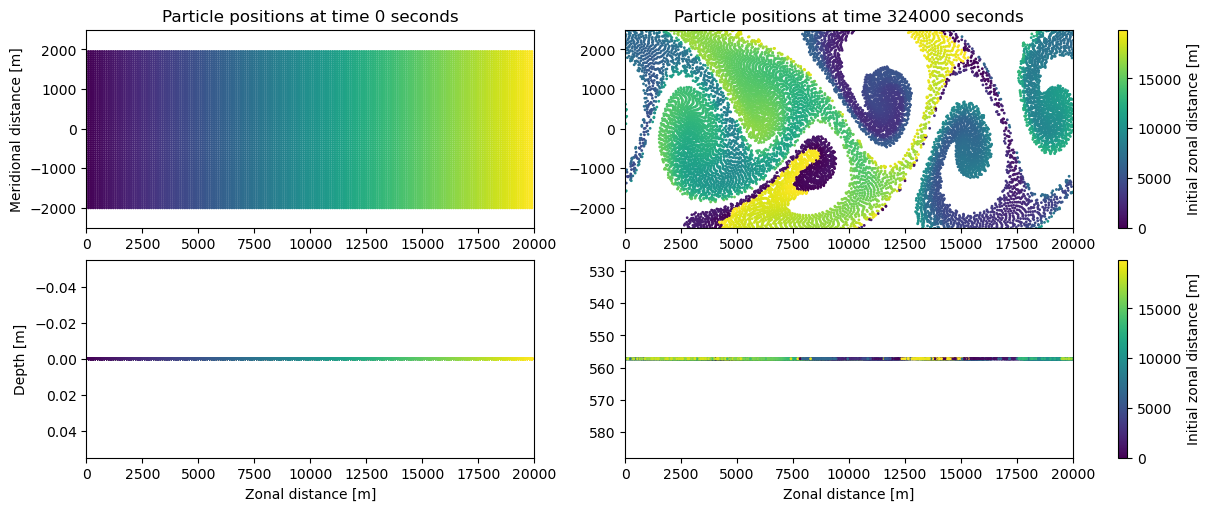

In [13]:
# Open the trajectory dataset and plot the particles
ds = xr.open_zarr(pfile.fname)
plot_particles(ds)

## Experiment 2: Idealised flow and wind
In this second experiment we will simulate the dispersion of particles by the idealised flow, including the effects of wind. Again, there may exist a density difference between the plastic particles and the background flow, resulting in a non-zero settling velocity until the particles become neutrally buoyant. However, only particles at the surface are affected by the wind, so we will make our particles positively buoyant by initialising them a low density. Since the particles are positively buoyant, they experience a negative settling velocity, that tries to push them through the surface, forcing us to make use of the `CheckErrorThroughSurface` kernel.

In [14]:
# Setting this particular experiments settings
fieldset.use_3D = True
fieldset.use_mixing = False
fieldset.use_biofouling = False
fieldset.use_stokes = False
fieldset.use_wind = True

settings['plastictype']['plastic_density'] = 1000.

In [15]:
# Create a particle set and particle file for the experiment
pset = pp.constructors.create_particleset(fieldset, settings, release_locations)
pfile = pp.ParticleFile('example_idealised_flow_experiment_2.zarr', pset, settings=settings, outputdt=outputdt)

# Create the applicable kernels to the plastic particles, replacing the longitudinal boundary kernel with a zonal boundary kernel
kernels = pp.constructors.create_kernel(fieldset)
kernels[-2] = ZonalBC

In [16]:
# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

INFO: Output files are stored in example_idealised_flow_experiment_2.zarr.
100%|██████████| 345600.0/345600.0 [00:55<00:00, 6278.37it/s]


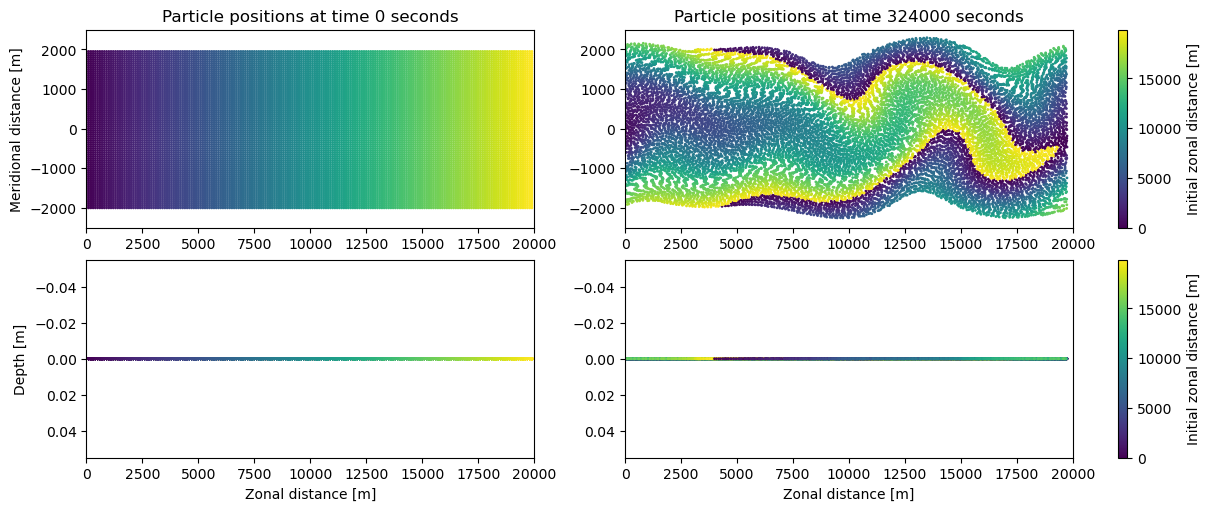

In [17]:
# Open the trajectory dataset and plot the particles
ds = xr.open_zarr(pfile.fname)
plot_particles(ds)

## Experiment 3: Idealised flow, wind, and waves
In this third experiment we will simulate the dispersion of particles by the idealised flow, including the effects of wind and waves. Again, there may exist a density difference between the plastic particles and the background flow, resulting in a non-zero settling velocity until the particles become neutrally buoyant. Only particles at the surface are affected by the wind, but all particles will experience a depth-decaying Stokes drift.

In [18]:
# Setting this particular experiments settings
fieldset.use_3D = True
fieldset.use_mixing = False
fieldset.use_biofouling = False
fieldset.use_stokes = True
fieldset.use_wind = True

settings['plastictype']['plastic_density'] = 1027.25

In [19]:
# Create a particle set and particle file for the experiment
pset = pp.constructors.create_particleset(fieldset, settings, release_locations)
pfile = pp.ParticleFile('example_idealised_flow_experiment_3.zarr', pset, settings=settings, outputdt=outputdt)

# Create the applicable kernels to the plastic particles, replacing the longitudinal boundary kernel with a zonal boundary kernel
kernels = pp.constructors.create_kernel(fieldset)
kernels[-2] = ZonalBC

In [20]:
# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

INFO: Output files are stored in example_idealised_flow_experiment_3.zarr.
100%|██████████| 345600.0/345600.0 [01:00<00:00, 5742.26it/s]


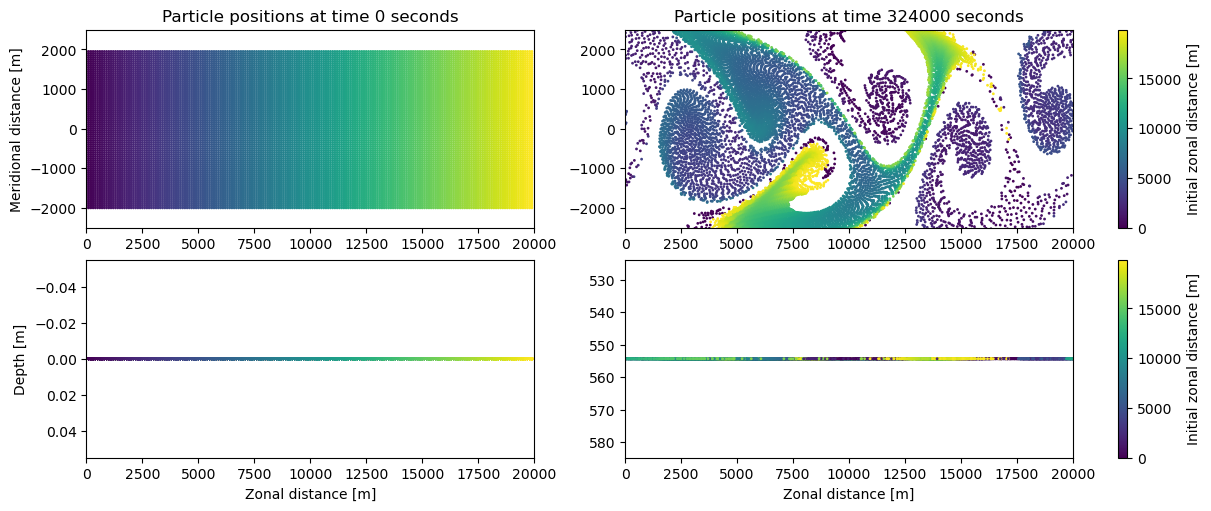

In [21]:
# Open the trajectory dataset and plot the particles
ds = xr.open_zarr(pfile.fname)
plot_particles(ds)

## Experiment 4: Idealised flow and biofouling
In this fourth experiment we will simulate the dispersion of particles by the idealised flow, including the effects of biofouling. Here, the actual effects of biofouling are somewhat minor, as the integration time of the experiment is only four days long. However, there are small differences in the final particle positions when compared to the particles advected by the flow alone, specifically, the depth profile of the particles is noticeably different! Note, we specifically turn off the respiration term in order for the algae to grow as much as possible in the short four day period.

In [22]:
# Setting this particular experiments settings
fieldset.use_3D = True
fieldset.use_mixing = False
fieldset.use_biofouling = True
fieldset.use_stokes = False
fieldset.use_wind = False

settings['plastictype']['plastic_density'] = 1027.275

In [23]:
# Create a particle set and particle file for the experiment
pset = pp.constructors.create_particleset(fieldset, settings, release_locations)
pfile = pp.ParticleFile('example_idealised_flow_experiment_4.zarr', pset, settings=settings, outputdt=outputdt)

# Create the applicable kernels to the plastic particles, replacing the longitudinal boundary kernel with a zonal boundary kernel
kernels = pp.constructors.create_kernel(fieldset)
kernels[-2] = ZonalBC

In [24]:
# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

INFO: Output files are stored in example_idealised_flow_experiment_4.zarr.
100%|██████████| 345600.0/345600.0 [00:53<00:00, 6502.73it/s]


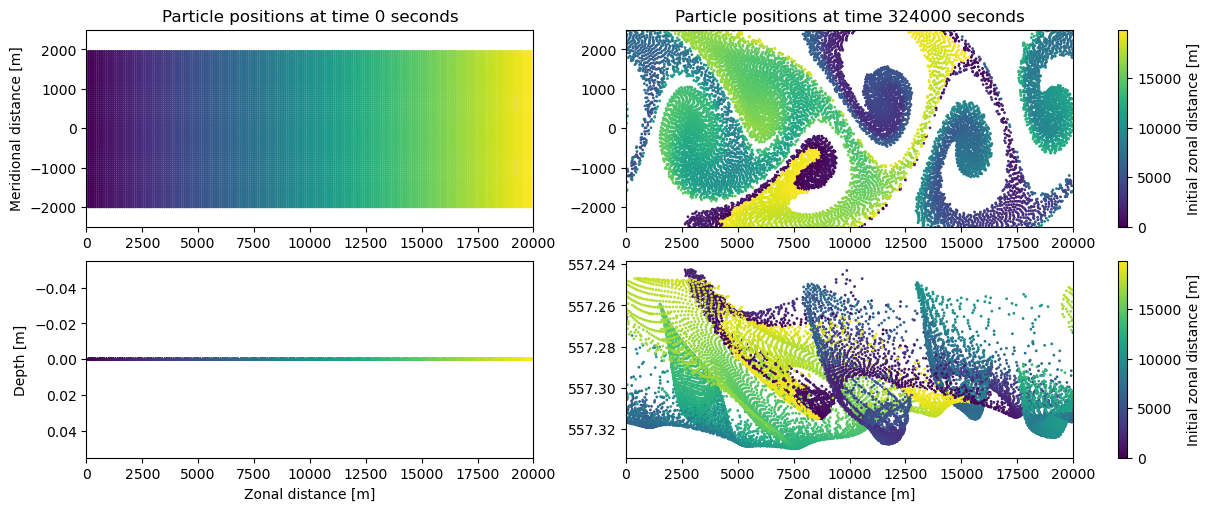

In [25]:
# Open the trajectory dataset and plot the particles
ds = xr.open_zarr(pfile.fname)
plot_particles(ds)

## Experiment 5: All effects
In this final experiment, we will simulate the dispersion of particles affected by all processes. That is, the particles will be advected by the idealised flow, including the effects of wind, waves, and biofouling.

In [26]:
# Setting this particular experiments settings
fieldset.use_3D = True
fieldset.use_mixing = False
fieldset.use_biofouling = True
fieldset.use_stokes = True
fieldset.use_wind = True

settings['plastictype']['plastic_density'] = 1027.275

In [27]:
# Create a particle set and particle file for the experiment
pset = pp.constructors.create_particleset(fieldset, settings, release_locations)
pfile = pp.ParticleFile('example_idealised_flow_experiment_5.zarr', pset, settings=settings, outputdt=outputdt)

# Create the applicable kernels to the plastic particles, replacing the longitudinal boundary kernel with a zonal boundary kernel
kernels = pp.constructors.create_kernel(fieldset)
kernels[-2] = ZonalBC

In [28]:
# Execute the simulation
pset.execute(kernels, runtime=runtime, dt=dt, output_file=pfile)

INFO: Output files are stored in example_idealised_flow_experiment_5.zarr.
100%|██████████| 345600.0/345600.0 [01:21<00:00, 4246.80it/s]


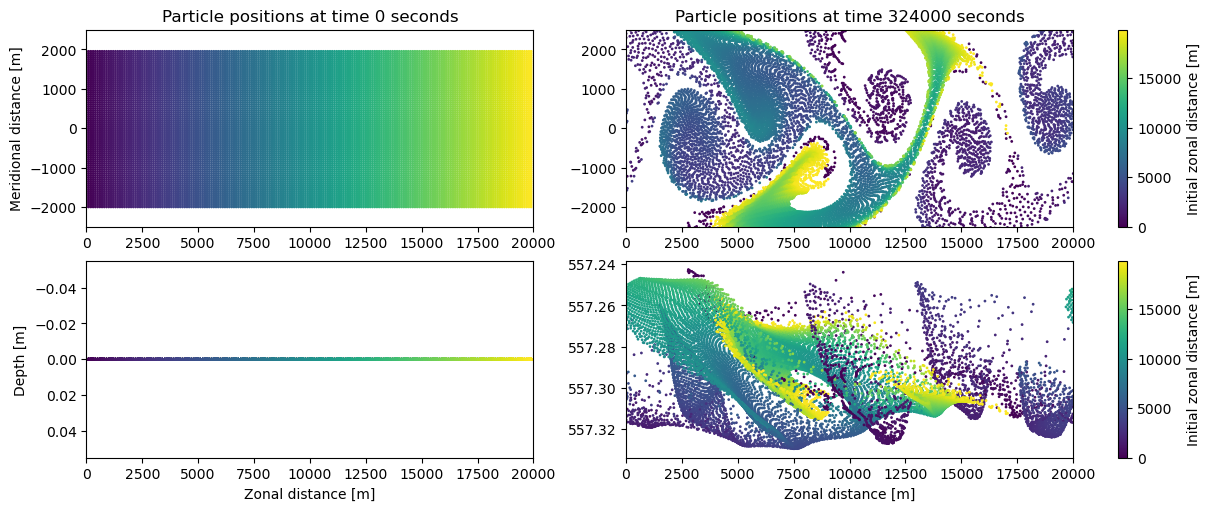

In [29]:
# Open the trajectory dataset and plot the particles
ds = xr.open_zarr(pfile.fname)
plot_particles(ds)

## Comparing the results of all five experiments
With all five experiments complete, we now plot the final positions of all particles to compare the effects of the different kernels.

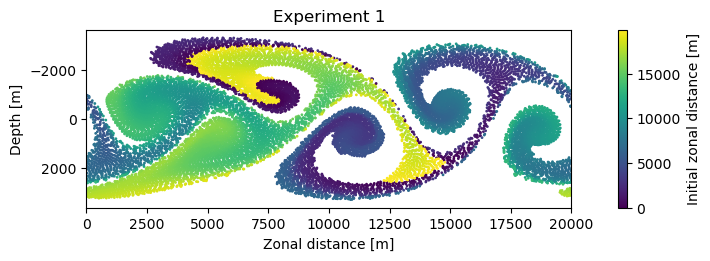

Final depth range of particles in experiment 1: 557.2360 to 557.2360 m


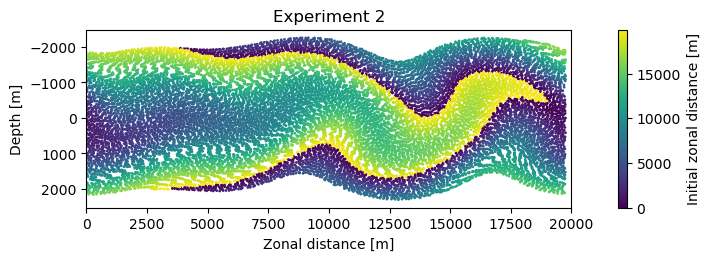

Final depth range of particles in experiment 2: 0.0000 to 0.0000 m


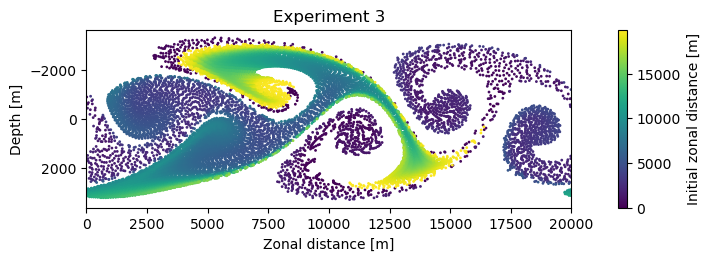

Final depth range of particles in experiment 3: 554.3013 to 554.3013 m


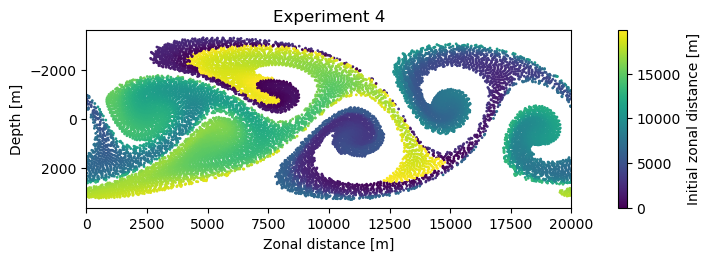

Final depth range of particles in experiment 4: 557.2427 to 557.3295 m


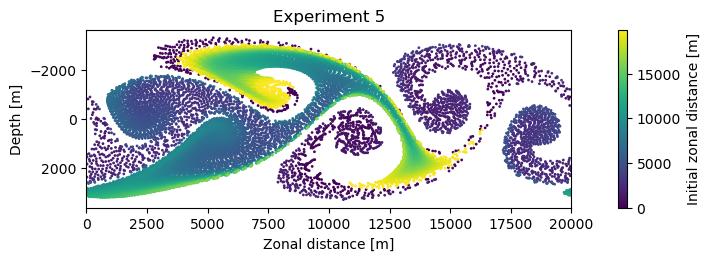

Final depth range of particles in experiment 5: 557.2427 to 557.3296 m


In [30]:
# List of experiment filenames
filenames = [f'example_idealised_flow_experiment_{i}.zarr' for i in range(1, 6)]

# Create a list of datasets
ds_list = []
for filename in filenames:
    ds_list.append(xr.open_zarr(filename))

# For each dataset, plot the final locations of the particles, and print the depth range of the particles
for i, pfile in enumerate(ds_list):
    fig = plt.figure(figsize=(7, 2.5), constrained_layout=True)
    
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Zonal distance [m]')
    ax.set_ylabel('Depth [m]')
    ax.set_xlim(0, 2e4)
    
    ax.yaxis.set_inverted(True)
    cb = ax.scatter(pfile['lon'].values[:,-2], pfile['lat'].values[:,-2], c=pfile['lon'].values[:,0], s=1)
    plt.colorbar(cb, label='Initial zonal distance [m]')
    plt.title(f'Experiment {i+1}')
    plt.show()

    print(f'Final depth range of particles in experiment {i+1}: {format(np.nanmin(pfile["z"].values[:,-1]), '.4f')} to {format(np.nanmax(pfile["z"].values[:,-1]), '.4f')} m')